# Functional connectivity and resting state

Functional connectivity and resting-state data can be studied in many different way. `Nilearn` provides tools to construct "connectomes" that capture functional interactions between regions or to extract regions and networks, via resting-state networks or parcellations. For a much more detailed guide, go to [Nilearn's Connectivity section](http://nilearn.github.io/connectivity/index.html), here we want to show you just a few basics.

Speaking of which, we will be covering the following sections:

1. Extracting times series to build a functional connectome
1. Single subject maps of seed-to-voxel correlation
1. Single subject maps of seed-to-seed correlation
1. Group analysis of resting-state fMRI with ICA (CanICA)

# Setup

Before we start with anything, let's set up the important plotting functions:

In [1]:
from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Also, let's specify which subjects we want to use for this notebook. So, who do we have?

In [2]:
!nib-ls /data/adhd/*/*.nii.gz

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz int16 [ 61,  73,  61,  90] 3.00x3.00x3.00x2.00
/data/adhd/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz int16 [ 61,  73,  61,  90] 3.00x3.00x3.00x2.00
/data/adhd/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz int16 [ 61,  73,  61,  90] 3.00x3.00x3.00x2.00
/data/adhd/0021019/0021019_rest_tshift_RPI_voreg_mni.nii.gz int16 [ 61,  73,  61,  90] 3.00x3.00x3.00x2.00
/data/adhd/0027018/0027018_rest_tshift_RPI_voreg_mni.nii.gz int16 [ 61,  73,  61,  90] 3.00x3.00x3.00x1.96
/data/adhd/0027034/0027034_rest_tshift_RPI_voreg_mni.nii.gz int16 [ 61,  73,  61,  90] 3.00x3.00x3.00x1.96
/data/adhd/0027037/0027037_rest_tshift_RPI_voreg_mni.nii.gz int16 [ 61,  73,  61,  90] 3.00x3.00x3.00x1.96
/data/adhd/1517058/1517058_rest_tshift_RPI_voreg_m

For each subject we also have a regressor file, containing important signal confounds such motion parameters, compcor components and mean signal in CSF, GM, WM, Overal. Let's take a look at one of those regressor files:

In [3]:
import pandas as pd
pd.read_table('/data/adhd/0010042/0010042_regressors.csv').head()

,csf,constant,linearTrend,wm,global,motion-pitch,motion-roll,motion-yaw,motion-x,motion-y,motion-z,gm,compcor1,compcor2,compcor3,compcor4,compcor5
0,12140.708282,1.0,0.0,9322.722489,9955.469315,-0.0637,0.1032,-0.1516,-0.0376,-0.0112,0.0840,10617.938409,-0.035058,-0.006713,-0.071532,0.009847,-0.027601
1,12123.146913,1.0,1.0,9314.257684,9947.987176,-0.0708,0.0953,-0.1562,-0.0198,0.0021,0.0722,10611.036827,-0.026949,-0.091152,-0.030126,0.020055,-0.099798
2,12085.963127,1.0,2.0,9319.610045,9945.132852,-0.0795,0.0971,-0.1453,-0.0439,-0.0241,0.0972,10591.877177,0.002552,0.069165,0.090166,-0.016608,-0.071980
3,12109.299348,1.0,3.0,9299.841075,9943.648622,-0.0607,0.0918,-0.1601,-0.0418,-0.0133,0.0877,10592.008336,0.079391,0.029959,-0.098036,0.062493,0.024105
4,12072.330305,1.0,4.0,9297.870869,9925.640852,-0.0706,0.0873,-0.1482,-0.0313,-0.0118,0.0712,10570.445905,0.075471,-0.030123,0.084739,0.088217,0.012996


So let's create two lists, containing the path to the resting-state images and confounds of all subjects:

In [4]:
cp -R /data/adhd/ /home/neuro/workshop/notebooks/.

In [5]:
# Which subjects to consider
sub_idx = ['0010042', '0010064', '0010128', '0021019', '0027018',
           '0027034', '0027037', '1517058', '1562298', '2497695',
           '2950754', '3007585', '3520880', '3994098', '4134561',
           '6115230', '8409791', '8697774', '9744150', '9750701']

In [6]:
# Path to resting state files
rest_files = ['/data/adhd/%s/%s_rest_tshift_RPI_voreg_mni.nii.gz' % (sub, sub) for sub in sub_idx]

In [7]:
# Path to counfound files
confound_files = ['/data/adhd/%s/%s_regressors.csv' % (sub, sub) for sub in sub_idx]

Perfect, now we're good to go!

# 1. Extracting times series to build a functional connectome

So let's start with something simple: Extracting activation time series from regions defined by a parcellation atlas.

## Brain parcellation

As a first step, let's define the regions we want to extract the signal from:

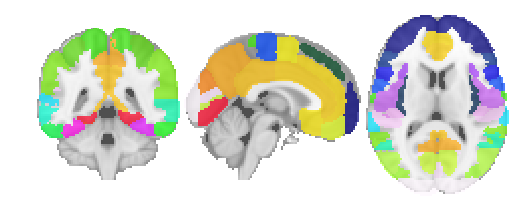

In [8]:
# Location of HarvardOxford parcellation atlas
atlas_file = '/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz'

# Visualize parcellation atlas
plotting.plot_roi(atlas_file, draw_cross=False, annotate=False);

In [9]:
# Load labels for each atlas region
with open('data/HarvardOxford_labels.txt', 'r') as f:
    labels = f.read().split('\n')
labels[:10]

['Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus-pars triangularis',
 'Inferior Frontal Gyrus-pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus-anterior division',
 'Superior Temporal Gyrus-posterior division']

## Extracting signals on a parcellation

To extract signal on the parcellation, the easiest option is to use `NiftiLabelsMasker`. As any "maskers" in nilearn, it is a processing object that is created by specifying all the important parameters, but not the data:

In [10]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_file, standardize=True, verbose=1,
                           memory="nilearn_cache", memory_level=2)

The Nifti data can then be turned to time-series by calling the `NiftiLabelsMasker` `fit_transform` method, that takes either filenames or NiftiImage objects.

Let's do this now for the first subject:

In [11]:
time_series = masker.fit_transform(rest_files[0], confounds=confound_files[0])

[NiftiLabelsMasker.fit_transform] loading data from /usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7f8ee825f2e8>, interpolation='nearest', target_shape=(61, 73, 61), target_affine=array([[  -3.,    0.,    0.,   90.],
       [   0.,    3.,    0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]]))
_____________________________________________________resample_img - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f8f02af1fd0>, 
{ 'background_label'

## Compute and display the correlation matrix

Now we're read to compute the functional connectome with `ConnectivityMeasure`.

In [12]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

And finally we can visualize this correlation matrix:

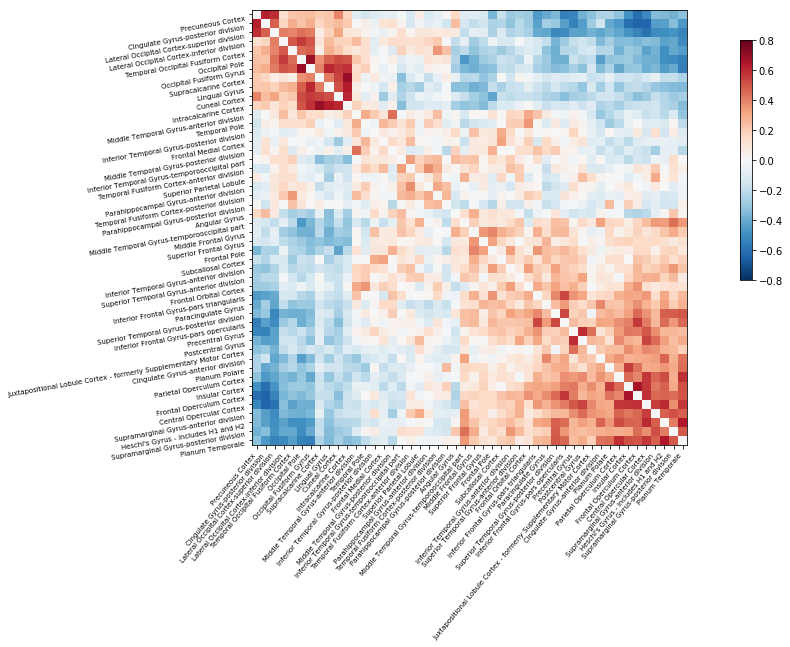

In [13]:
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# Plot correlation matrix - note: matrix is ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True);

## Same thing without confounds, to stress the importance of confounds

Let's do the same thing as before, but this time without using the confounds.

[NiftiLabelsMasker.fit_transform] loading data from /usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f8ee4f75f98>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(cachedir='nilearn_cache/joblib'), memory_level=2, verbose=1)
[NiftiLabelsMasker.transform_single_imgs] Loading data from /data/adhd/0010042/0010042_rest_tshif

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  memory_level=memory_level)(imgs)


[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f8ee4727128>)
____________________________________nifti_labels_masker_extractor - 0.5s, 0.0min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[8178, ..., 8028],
       ...,
       [8193, ..., 8161]], dtype=int16), detrend=False, standardize=True, t_r=None, low_pass=None, high_pass=None, confounds=None, sessions=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 1.0s, 0.0min


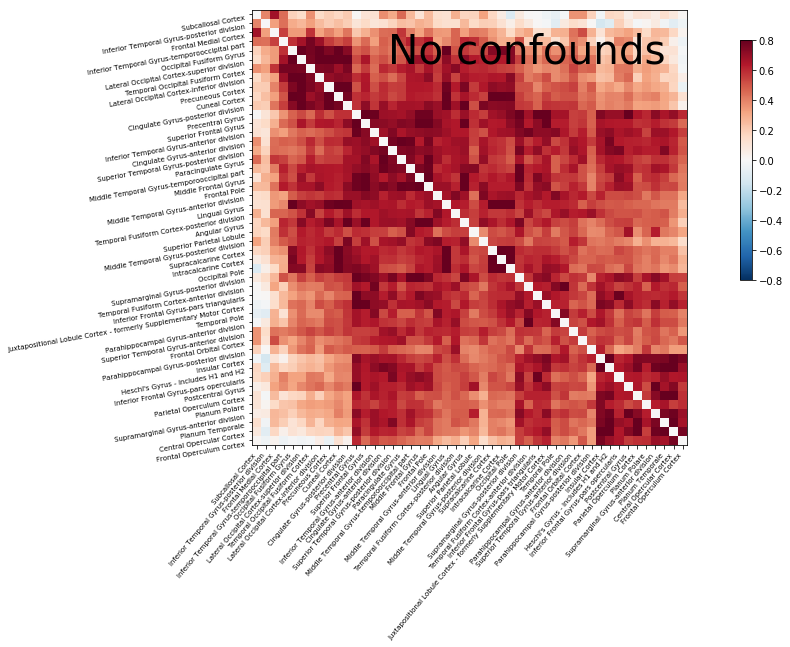

In [14]:
# Extract the signal from the regions
time_series_bad = masker.fit_transform(rest_files[0]) # Note that we haven't specify confounds here

# Compute the correlation matrix
correlation_matrix_bad = correlation_measure.fit_transform([time_series_bad])[0]

# Mask the main diagonal for visualization
np.fill_diagonal(correlation_matrix_bad, 0)

# Plot the correlation matrix
plotting.plot_matrix(correlation_matrix_bad, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, title='No confounds', reorder=True)

As you can see, without any confounds all regions are connected to each other! One reference that discusses the importance of confounds is [Varoquaux & Craddock 2013](http://www.sciencedirect.com/science/article/pii/S1053811913003340).

## Probabilistic atlas

Above we used a parcellation atlas. Now, with nilearn, you can do the same thing also with a probabilistic atlas. Let's use for example the [MSDL atlas](https://team.inria.fr/parietal/18-2/spatial_patterns/spatial-patterns-in-resting-state/).

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


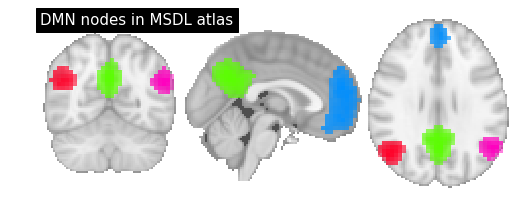

In [15]:
# Path to MSDL atlas
msdl_atlas = 'data/msdl_atlas/MSDL_rois/msdl_rois.nii'

# Extract only default mode network nodes
dmn_nodes = image.index_img(msdl_atlas, [3, 4, 5, 6])

# Plot MSDL probability atlas
plotting.plot_prob_atlas(dmn_nodes, cut_coords=(0, -60, 29), draw_cross=False,
                         annotate=False, title="DMN nodes in MSDL atlas")

The only difference to before is that we now need to use the `NiftiMapsMasker` function to create the masker that extracts the time series:

In [16]:
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=msdl_atlas, standardize=True, verbose=1,
                         memory="nilearn_cache", memory_level=2)

Now, as before

In [17]:
# Extract the signal from the regions
time_series = masker.fit_transform(rest_files[0], confounds=confound_files[0])

# Compute the correlation matrix
correlation_matrix= correlation_measure.fit_transform([time_series])[0]

# Mask the main diagonal for visualization
np.fill_diagonal(correlation_matrix, 0)

[NiftiMapsMasker.fit_transform] loading regions from data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7f8ee461cef0>, interpolation='continuous', target_shape=(61, 73, 61), target_affine=array([[  -3.,    0.,    0.,   90.],
       [   0.,    3.,    0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]]))
_____________________________________________________resample_img - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', <nilearn.input_data.nifti_maps_masker._ExtractionFunctor object at 0x7f8ee461ce80>, 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'h

Before we plot the new correlation matrix, we also need to load the labels of the MSDL atlas:

In [18]:
# CSV containing label and coordinate of MSDL atlas
msdl_info = 'data/msdl_atlas/MSDL_rois/msdl_rois_labels.csv'

# Load the name and coordinates of the labels
content = pd.read_csv(msdl_info)

In [19]:
# Read out label names
labels = content['name'].tolist()
labels[:10]

['L Aud',
 'R Aud',
 'Striate',
 'L DMN',
 'Med DMN',
 'Front DMN',
 'R DMN',
 'Occ post',
 'Motor',
 'R DLPFC']

In [20]:
# Read out label coordinats
coords = np.array(content[['x', 'y', 'z']])
coords[:10]

array([[-53.28,  -8.88,  32.36],
       [ 53.47,  -6.49,  27.52],
       [  1.18, -74.54,  10.79],
       [-45.8 , -64.78,  31.84],
       [ -0.2 , -55.21,  29.87],
       [ -0.15,  51.42,   7.58],
       [ 51.66, -59.34,  28.88],
       [  0.41, -91.05,   1.58],
       [ -1.48, -27.93,  61.5 ],
       [ 40.1 ,  20.96,  44.72]])

Perfect! Now as before, we can plot the correlation matrix as follows:

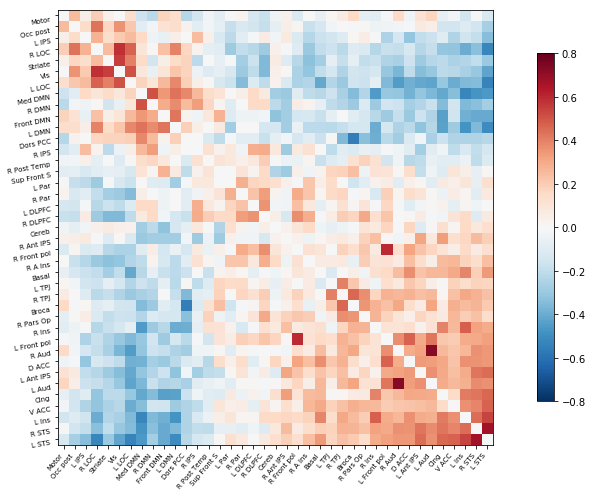

In [21]:
# Plot the correlation matrix
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

## Display corresponding graph on glass brain

A square matrix, such as a correlation matrix, can also be seen as a "graph": a set of "nodes", connected by "edges". When these nodes are brain regions, and the edges capture interactions between them, this graph is a "functional connectome".

As the MSDL atlas comes with (x, y, z) MNI coordinates for the different regions, we can visualize the matrix as a graph of interaction in a brain. To avoid having too dense a graph, we represent only the 20% edges with the highest values. For another atlas this information can be computed for each region with the `nilearn.plotting.find_xyz_cut_coords` function:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


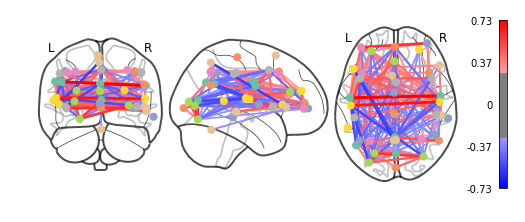

In [22]:
plotting.plot_connectome(correlation_matrix, coords, edge_threshold="80%",
                         colorbar=True)

As you can see, the correlation matrix gives a very "full" graph: every node is connected to every other one. This is because it also captures indirect connections.

From version `0.5.0` on, `nilearn` also provides an interactive plot for connectoms:

In [ ]:
plotting.view_connectome(correlation_matrix, coords, threshold="80%", cmap='bwr',
                         symmetric_cmap=False, linewidth=6.0, marker_size=3.0)

# 2. Single subject maps of seed-to-voxel correlation

Above we computed the correlation between different regions. But what if we want to compute a seed-to-voxel correlation map for a single subject? The procedure is very similar to the one from before.

## Time series extraction

First, we need to extract the time series from the seed region. For this example, let's specify a sphere of radius 8 (in mm) located in the Posterior Cingulate Cortex. This sphere is considered to be part of the Default Mode Network.

In [24]:
# Sphere radius in mm
sphere_radius = 8

# Sphere center in MNI-coordinate
sphere_coords = [(0, -52, 18)]

In this case, we will use We use the `NiftiSpheresMasker` function to extract the time series within a given sphere. Before signal extraction, we can also directly detrend, standardize, and bandpass filter the data.

In [25]:
from nilearn.input_data import NiftiSpheresMasker
seed_masker = NiftiSpheresMasker(sphere_coords, radius=sphere_radius, detrend=True,
                                 standardize=True, low_pass=0.1, high_pass=0.01,
                                 t_r=2.0, verbose=1, memory="nilearn_cache", memory_level=2)

Now we're read to extract the mean time series within the seed region, while also regressing out the confounds.

In [26]:
seed_time_series = seed_masker.fit_transform(rest_files[0], confounds=confound_files[0])

________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', <nilearn.input_data.nifti_spheres_masker._ExtractionFunctor object at 0x7f8ede4b2630>, 
{ 'allow_overlap': False,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(0, -52, 18)],
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': 2.0}, confounds='/data/adhd/0010042/0010042_regressors.csv', dtype=None, memory=Memory(cachedir='nilearn_cache/joblib'), memory_level=2, verbose=1)
[NiftiSpheresMasker.transform_single_imgs] Loading data from /data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.input_data.ni

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Next, we need to do a similar procedure for each voxel in the brain as well. For this, we can use the `NiftiMasker`, which the same arguments as before, plus additionally smoothing the signal with a smoothing kernel of 6mm.

In [27]:
from nilearn.input_data import NiftiMasker
brain_masker = NiftiMasker(smoothing_fwhm=6, detrend=True, standardize=True,
                           low_pass=0.1, high_pass=0.01, t_r=2., verbose=1,
                           memory="nilearn_cache", memory_level=2)

Now we can extract the time series for every voxel while regressing out the confounds:

In [28]:
brain_time_series = brain_masker.fit_transform(rest_files[0], confounds=confound_files[0])

[NiftiMasker.fit] Loading data from /data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMasker.fit] Computing the mask
________________________________________________________________________________
[Memory] Calling nilearn.masking.compute_background_mask...
compute_background_mask('/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', verbose=0)
__________________________________________compute_background_mask - 0.5s, 0.0min
[NiftiMasker.fit] Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7f8ede42f470>, target_affine=None, target_shape=None, copy=False)
_____________________________________________________resample_img - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask('/data/ad

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


____________________________________________________________clean - 9.1s, 0.2min
_________________________________________________filter_and_mask - 10.9s, 0.2min


## Performing the seed-based correlation analysis

Now that we have two arrays (mean signal in seed region, signal for each voxel), we can correlate the two to each other. This can be done with the dot product between the two matrices.

**Note**, that the signals have been variance-standardized during extraction. To have them standardized to
norm unit, we further have to divide the result by the length of the time series.

In [29]:
seed_based_correlations = np.dot(brain_time_series.T, seed_time_series)
seed_based_correlations /= seed_time_series.shape[0]

## Plotting the seed-based correlation map

Finally, we can tranform the correlation array back to a Nifti image. 

In [30]:
seed_based_correlation_img = brain_masker.inverse_transform(seed_based_correlations.T)

________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0.178762, ..., -0.126503]], dtype=float32), <nibabel.nifti1.Nifti1Image object at 0x7f8ede42f470>)
___________________________________________________________unmask - 0.0s, 0.0min


And this we can of course plot again to better investigate the correlation outcome:

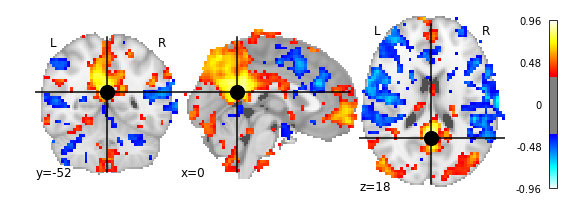

In [31]:
display = plotting.plot_stat_map(seed_based_correlation_img, threshold=0.333,
                                 cut_coords=sphere_coords[0])
display.add_markers(marker_coords=sphere_coords, marker_color='black',
                    marker_size=200)

The map above depicts the temporal correlation of a **seed region** with the **rest of the brain**. For a similar example but on the cortical surface, see [this example](http://nilearn.github.io/auto_examples/01_plotting/plot_surf_stat_map.html#seed-based-connectivity-on-the-surface).

# 3. Single subject maps of seed-to-seed correlation

The next question is of course, how can compute the correlation between different seed regions?  It's actually very easy, even simpler than above.

## Time series extraction

First, we need to extract the time series from the seed regions. So as before, we need to define a sphere radius and centers of the seed regions:

In [32]:
# Sphere radius in mm
sphere_radius = 8

# Sphere center in MNI-coordinate
sphere_center = [(  0, -52, 18),
                 (-46, -68, 32),
                 ( 46, -68, 32),
                 (  1,  50, -5)]

Now we can extract the time series from those spheres:

In [33]:
# Create masker object to extract average signal within spheres
from nilearn.input_data import NiftiSpheresMasker
masker = NiftiSpheresMasker(sphere_center, radius=sphere_radius, detrend=True,
                            standardize=True, low_pass=0.1, high_pass=0.01,
                            t_r=2.0, verbose=1, memory="nilearn_cache", memory_level=2)

In [34]:
# Extract average signal in spheres with masker object
time_series = masker.fit_transform(rest_files[0], confounds=confound_files[0])

________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', <nilearn.input_data.nifti_spheres_masker._ExtractionFunctor object at 0x7f8ede47e1d0>, 
{ 'allow_overlap': False,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)],
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': 2.0}, confounds='/data/adhd/0010042/0010042_regressors.csv', dtype=None, memory=Memory(cachedir='nilearn_cache/joblib'), memory_level=2, verbose=1)
[NiftiSpheresMasker.transform_single_imgs] Loading data from /data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_spheres_masker_extractor'
  memory_level=memory_level)(imgs)


[NiftiSpheresMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_spheres_masker.nifti_spheres_masker_extractor...
nifti_spheres_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7f8ee44cddd8>)
___________________________________nifti_spheres_masker_extractor - 2.0s, 0.0min
[NiftiSpheresMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[10273, ..., 12400],
       ...,
       [10254, ..., 12444]], dtype=int16), detrend=True, standardize=True, t_r=2.0, low_pass=0.1, high_pass=0.01, confounds='/data/adhd/0010042/0010042_regressors.csv', sessions=None)
____________________________________________________________clean - 0.0s, 0.0min
_______________________________________________filter_and_extract - 2.6s, 0.0min


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


## Display mean signal per sphere

If we want, we can even plot the average signal per sphere:

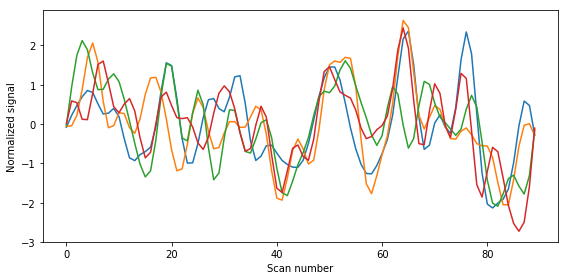

In [35]:
fig = plt.figure(figsize=(8, 4))
plt.plot(time_series)
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout();

## Compute partial correlation matrix

Now that we have the average signal per sphere we can compute the partial correlation matrix, using the `ConnectivityMeasure` function.

In [36]:
from nilearn.connectome import ConnectivityMeasure
connectivity_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrix = connectivity_measure.fit_transform([time_series])[0]

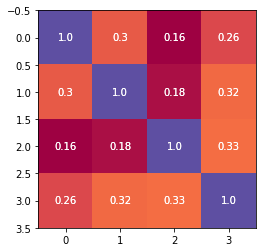

In [37]:
# Plotting the partical correlation matrix
fig, ax = plt.subplots()
plt.imshow(partial_correlation_matrix, cmap='Spectral')
for (j,i),label in np.ndenumerate(partial_correlation_matrix):
    ax.text(i, j, round(label, 2), ha='center', va='center', color='w')
    ax.text(i, j, round(label, 2), ha='center', va='center', color='w')

## Display connectome

Now that we have the correlation matrix, we can also plot it again on the glass brain with `plot_connectome`:

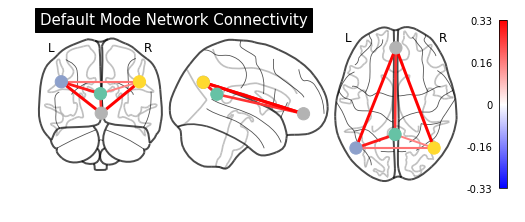

In [38]:
from nilearn.plotting import plot_connectome
plot_connectome(partial_correlation_matrix, sphere_center,
                display_mode='ortho', colorbar=True,  node_size=150,
                title="Default Mode Network Connectivity")

And again with `nilearn`'s interactive connectome viewer function:

In [ ]:
plotting.view_connectome(partial_correlation_matrix, sphere_center, cmap='bwr',
                         symmetric_cmap=True, linewidth=6.0, marker_size=10.0)

# 4. Group analysis of resting-state fMRI with ICA (CanICA)

This section demonstrates the use of multi-subject Independent Component Analysis (ICA) of resting-state fMRI data to extract brain networks in a data-driven way. Here we use the `CanICA` approach, that implements a multivariate random effects model across subjects. Afterward this, we will also show a newer technique, based on dictionary learning.

## Multi-subject ICA: CanICA

`CanICA` is a ready-to-use object that can be applied to multi-subject Nifti data, for instance, presented as filenames, and will perform a multi-subject ICA decomposition following the `CanICA` model.

In [40]:
from nilearn.decomposition import CanICA

# Number of components to extract
n_components = 20

# Creating the CanICA object
canica = CanICA(n_components=n_components,
                smoothing_fwhm=6.,
                threshold=3.,
                random_state=0,
                n_jobs=-1,
                verbose=1)

As with every object in nilearn, we give its parameters at construction, and then fit it on the data.

In [41]:
canica.fit(rest_files)

[MultiNiftiMasker.fit] Loading data from [/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /data/adhd/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /data/adhd/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz, /data/adhd/00210
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/1562298/1562298_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/0027034/0027034_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/2497695/2497695_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/8697774/8697774_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/9744150/9744150_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/8409791/8409791_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/9750701/9750701_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_sin

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.5s finished
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
    mask_args=None, mask_strategy='epi', memory=Memory(cachedir=None),
    memory_level=0, n_components=20, n_init=10, n_jobs=-1, random_state=0,
    smoothing_fwhm=6.0, standardize=True, t_r=None, target_affine=None,
    target_shape=None, threshold=3.0, verbose=1)

Once `CanICA`has finished we can retrieve the independent components directly in brain space.

In [42]:
components_img = canica.components_img_

## Visualizing CanICA components

To visualize the components we can plot the outline of all components in one figure.

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


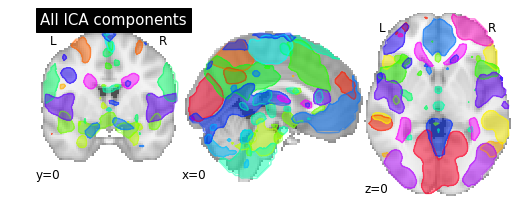

In [43]:
# Plot all ICA components together
plotting.plot_prob_atlas(components_img, draw_cross=False, linewidths=None,
                         cut_coords=[0, 0, 0], title='All ICA components');

We can of course also plot the ICA components separately using the `plot_stat_map` and `iter_img`. Let's plot the first few components:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:310: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


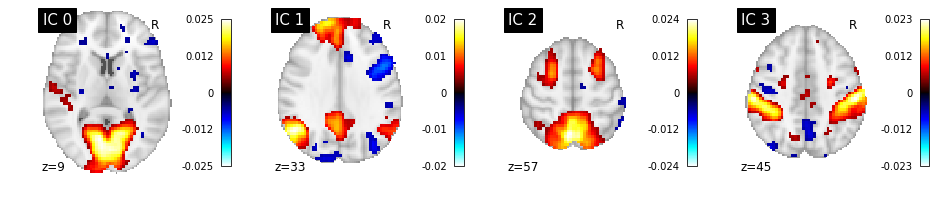

In [44]:
# Extract first few components
first_few_comp = components_img.slicer[..., :4]

# Plot first few components
fig = plt.figure(figsize=(16, 3))
for i, cur_img in enumerate(image.iter_img(first_few_comp)):
    ax = fig.add_subplot(1, 4, i + 1)
    plotting.plot_stat_map(cur_img, display_mode="z", title="IC %d" % i, 
                  cut_coords=1, colorbar=True, axes=ax)

## Beyond ICA : Dictionary learning

Recent work has shown that **dictionary learning** based techniques outperform ICA in term of stability and constitutes a better first step in a statistical analysis pipeline. Dictionary learning in neuroimaging seeks to extract a few representative temporal elements along with their ***sparse spatial loadings***, which constitute good extracted maps.

So let's do the same thing again as above, but this time with `DictLearning`

In [45]:
# Import dictionary learning algorithm
from nilearn.decomposition import DictLearning

In [46]:
# Initialize DictLearning object
dict_learn = DictLearning(n_components=n_components,
                          smoothing_fwhm=6.,
                          random_state=0,
                          n_jobs=-1,
                          verbose=1)

Now we're ready and can apply the dictionar learning object on the functional data:

In [47]:
# Fit to the data
dict_learn.fit(rest_files)

[MultiNiftiMasker.fit] Loading data from [/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /data/adhd/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /data/adhd/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz, /data/adhd/00210
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/0027034/0027034_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/2497695/2497695_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing im

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/signal.py:59: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((signals ** 2).sum(axis=0))


[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/9750701/9750701_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/8409791/8409791_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/8697774/8697774_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/data/adhd/9744150/9744150_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_s

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[DictLearning] Computing initial loadings
[DictLearning] Learning dictionary


DictLearning(alpha=10, batch_size=20, detrend=True, dict_init=None,
       high_pass=None, low_pass=None, mask=None, mask_args=None,
       mask_strategy='epi', memory=Memory(cachedir=None), memory_level=0,
       method='cd', n_components=20, n_epochs=1, n_jobs=-1, random_state=0,
       reduction_ratio='auto', smoothing_fwhm=6.0, standardize=True,
       t_r=None, target_affine=None, target_shape=None, verbose=1)

As before, we can now retrieve the independent components directly in brain space.

In [48]:
components_img = dict_learn.components_img_

## Visualizing DictLearning components

To visualize the components we can plot the outline of all components in one figure.

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


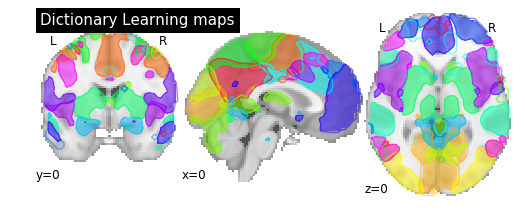

In [49]:
# Plot all ICA components together
plotting.plot_prob_atlas(components_img, draw_cross=False, linewidths=None,
                         cut_coords=[0, 0, 0], title='Dictionary Learning maps');

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:310: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


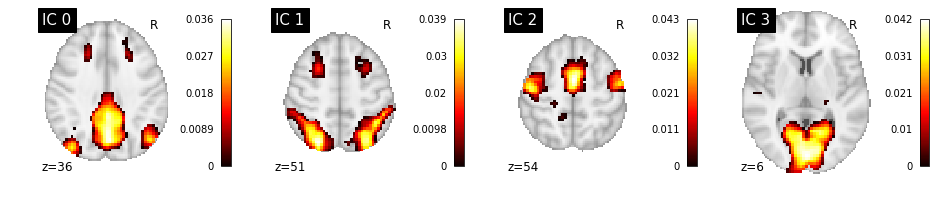

In [50]:
# Extract first few components
first_few_comp = components_img.slicer[..., :4]

# Plot first few components
fig = plt.figure(figsize=(16, 3))
for i, cur_img in enumerate(image.iter_img(first_few_comp)):
    ax = fig.add_subplot(1, 4, i + 1)
    plotting.plot_stat_map(cur_img, display_mode="z", title="IC %d" % i, 
                  cut_coords=1, colorbar=True, axes=ax)

## Compare ICA to DictLearning

Now let's compare the two approaches by looking at some components:

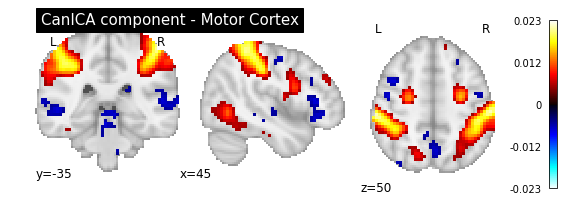

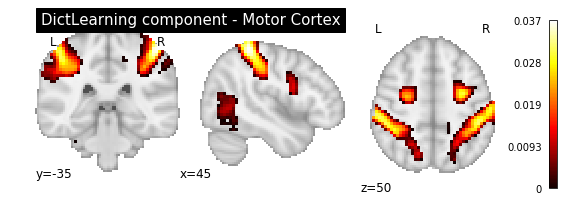

In [69]:
plotting.plot_stat_map(canica.components_img_.slicer[..., 3], display_mode='ortho',
                       cut_coords=[45, -35, 50], colorbar=True, draw_cross=False,
                       title='CanICA component - Motor Cortex')
plotting.plot_stat_map(dict_learn.components_img_.slicer[..., 19], display_mode='ortho',
                       cut_coords=[45, -35, 50], colorbar=True, draw_cross=False,
                       title='DictLearning component - Motor Cortex')

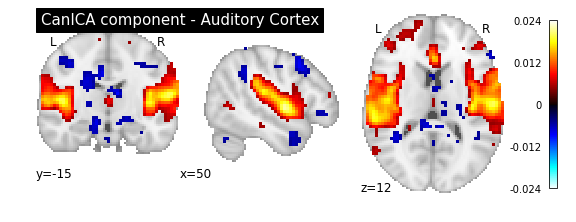

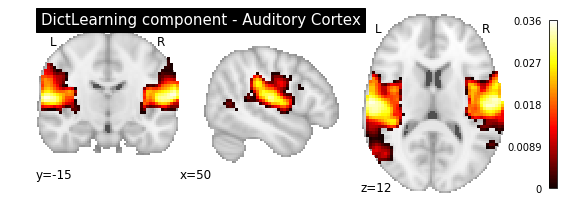

In [74]:
plotting.plot_stat_map(canica.components_img_.slicer[..., 16],  display_mode='ortho',
                       cut_coords=[50, -15, 12], colorbar=True, draw_cross=False,
                       title='CanICA component - Auditory Cortex')
plotting.plot_stat_map(dict_learn.components_img_.slicer[..., 16],  display_mode='ortho',
                       cut_coords=[50, -15, 12], colorbar=True, draw_cross=False,
                       title='DictLearning component - Auditory Cortex')

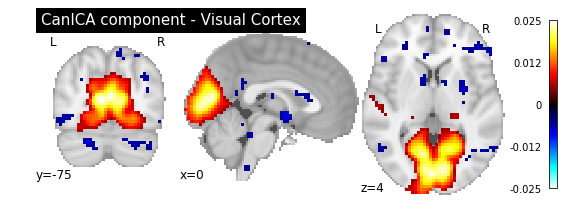

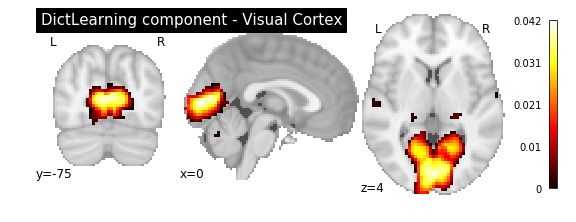

In [64]:
plotting.plot_stat_map(canica.components_img_.slicer[..., 0], display_mode='ortho',
                       cut_coords=[0, -75, 4], colorbar=True, draw_cross=False,
                       title='CanICA component - Visual Cortex')
plotting.plot_stat_map(dict_learn.components_img_.slicer[..., 3], display_mode='ortho',
                       cut_coords=[0, -75, 4], colorbar=True, draw_cross=False,
                       title='DictLearning component - Visual Cortex')

As you can see, the CanICA components looks much more noise, while the DictLearning components look sparser and more blobby. This becomes even more striking when we look at the corresponding glass brain plot:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/ma/core.py:3201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


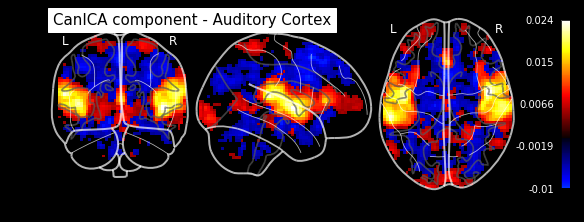

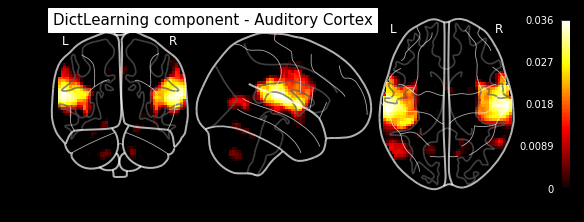

In [77]:
plotting.plot_glass_brain(canica.components_img_.slicer[..., 16], black_bg=True,
                          plot_abs=False, symmetric_cbar=False,
                          title='CanICA component - Auditory Cortex', colorbar=True)
plotting.plot_glass_brain(dict_learn.components_img_.slicer[..., 16], black_bg=True,
                          title='DictLearning component - Auditory Cortex', colorbar=True)

Maps obtained with dictionary leaning are often easier to exploit as they are less noisy than ICA maps, with blobs usually better defined. Typically, smoothing can be lower than when doing ICA. While dictionary learning computation time is comparable to CanICA, obtained atlases have been shown to outperform ICA in a variety of classification tasks.

## Extract functional connectome based on dictionary learning components

Similar to the very first section of this notebook, we can now take the components from the dictionary learning and compute a correlation matrix between the regions defined by the components.

We will be using nilearn's `RegionExtractor` to extract brain connected regions from the dictionary maps. We will be using the automatic thresholding strategy `ratio_n_voxels`. We use this thresholding strategy to first get foreground information present in the maps and then followed by robust region extraction on foreground information using Random Walker algorithm selected as `extractor='local_regions'`.

In [55]:
from nilearn.regions import RegionExtractor
extractor = RegionExtractor(dict_learn.components_img_, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions', verbose=1,
                            standardize=True, min_region_size=1350)

Here, we control foreground extraction using parameter `threshold=0.5`, which represents the expected proportion of voxels included in the regions (i.e. with a non-zero value in one of the maps). If you need to keep more proportion of voxels then threshold should be tweaked according to the maps data.

The parameter `min_region_size=1350 mm^3` is to keep the minimum number of extracted regions. We control the small spurious regions size by thresholding in voxel units to adapt well to the resolution of the image. Please see the documentation of [`nilearn.regions.connected_regions`](http://nilearn.github.io/modules/generated/nilearn.regions.connected_regions.html#nilearn.regions.connected_regions) for more details.

In [56]:
extractor.fit()

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[RegionExtractor.fit] loading regions from Nifti1Image(
shape=(61, 73, 61, 82),
affine=array([[  -3.,    0.,    0.,   90.],
       [   0.,    3.,    0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])
)


RegionExtractor(detrend=False, extractor='local_regions', high_pass=None,
        low_pass=None,
        maps_img=<nibabel.nifti1.Nifti1Image object at 0x7f8ebc4dd668>,
        mask_img=None, memory=Memory(cachedir=None), memory_level=0,
        min_region_size=1350, smoothing_fwhm=6, standardize=True, t_r=None,
        threshold=0.5, thresholding_strategy='ratio_n_voxels', verbose=1)

So how many regions did we extract?

In [57]:
# Total number of regions extracted
n_regions_extracted = extractor.regions_img_.shape[-1]
n_regions_extracted

82

Now, to get the average functional connectome over all subjects we need to compute the correlation matrix for each subject individually and than average those matrices into one.

In [58]:
from nilearn.connectome import ConnectivityMeasure

# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')

# Iterate over the subjects and compute correlation matrix for each
correlations = []
for filename, confound in zip(rest_files, confound_files):
    
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    
    correlations.append(correlation)

# Get array in good numpy structure
correlations = np.squeeze(correlations)

[RegionExtractor.transform_single_imgs] Loading data from /data/adhd/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[RegionExtractor.transform_single_imgs] Smoothing images
[RegionExtractor.transform_single_imgs] Extracting region signals
[RegionExtractor.transform_single_imgs] Cleaning extracted signals
[RegionExtractor.transform_single_imgs] Loading data from /data/adhd/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz
[RegionExtractor.transform_single_imgs] Smoothing images
[RegionExtractor.transform_single_imgs] Extracting region signals
[RegionExtractor.transform_single_imgs] Cleaning extracted signals
[RegionExtractor.transform_single_imgs] Loading data from /data/adhd/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz
[RegionExtractor.transform_single_imgs] Smoothing images
[RegionExtractor.transform_single_imgs] Extracting region signals
[RegionExtractor.transform_single_imgs] Cleaning extracted signals
[RegionExtractor.transform_single_imgs] Loading data from /data/adhd/0021019

Now that this is all computed, we can take the average correlation matrix and plot it:

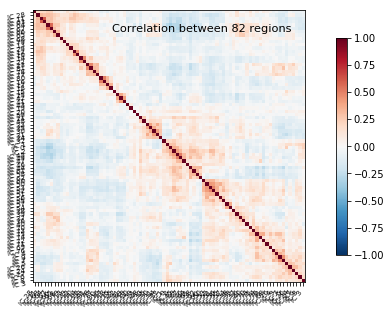

In [59]:
# Computing the mean correlation matrix
mean_correlations = np.mean(correlations, axis=0)

# Plot the average correlation matrix
title = 'Correlation between %d regions' % n_regions_extracted
plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1, colorbar=True,
                     labels=['IC %0d' % i for i in range(n_regions_extracted)],
                     title=title, reorder=True)

And as a last step, let's plot the average function connectome, based on the dictionary learning components also on the glass brain.

For this to work, we first need to find the center of the regions. Luckily nilearn provides a nice function, called `find_xyz_cut_coords` that does exactly that.

In [60]:
# Find the center of the regions with find_xyz_cut_coords
coords_connectome = [plotting.find_xyz_cut_coords(img)
                     for img in image.iter_img(extractor.regions_img_)]

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


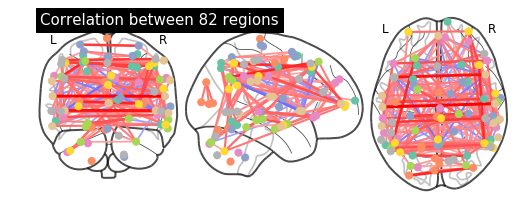

In [61]:
# Plot the functional connectome on the glass brain
plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='95%', title=title)